# Analyzing Sentiment Trends with Twitter Data

In this notebook, I'm going to match up the tweets to an assigned sentiment, clean up the text data for modeling, and then run a cluster analysis. 

In [24]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
pd.set_option('display.max_colwidth', -1)
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/twint_scraped_clean.csv',  usecols=['date', 'tweet', 'geo'])

In [4]:
df.head()

,date,tweet,geo
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago


I've read in the cleaned up data pulled with Twint. Now I'm going to use regex to remove a lot of the stuff in the tweets that I don't want to factor into my analysis, such as links, symbols, and @handles. 

## Cleaning Text with Regex

In [5]:
#creating a new clean column to remove URLs and @ mentions
df['clean_text'] = df['tweet']

#removing links
df['clean_text'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]
df['clean_text'] = [re.sub(r'(https://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]

#removing handles
df['clean_text'] = [re.sub(r'@[^\s]+', '', tweet) for tweet in df['clean_text']]

#removing hashtag symbols but keeping the words
df['clean_text'] = [re.sub(r"#", " ", tweet) for tweet in df['clean_text']]

#twint is pulling in this weird character for apostrophes so I'm replacing it
df['clean_text'] = [re.sub(r"â€™", "'", tweet) for tweet in df['clean_text']]


Much better, I can now focus on the content of the text.

In [6]:
df.head()

,date,tweet,geo,clean_text
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped."
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist."


## Assinging a Sentiment with Textblob

I'm using the Textblob library which can run a polarity score to analyze the text content to determine how negative or positive it is on a scale. While this capability isn't perfect, it can do a great job of assigning sentiment across large datasets quickly.

After creating a function to score the text, I am adding a column to display the score and another column to classify that score based on Textblob's guidelines.

In [7]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [8]:
# new column to display scores
df['tb_polarity'] = df['clean_text'].apply(get_polarity)

In [9]:
#new column to label sentiment based on score
df['tb_sentiment']=''
df.loc[df.tb_polarity>0,'tb_sentiment']='positive'
df.loc[df.tb_polarity==0,'tb_sentiment']='neutral'
df.loc[df.tb_polarity<0,'tb_sentiment']='negative'

In [52]:
df.head(20)

,date,tweet,geo,clean_text,tb_polarity,tb_sentiment
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped.",0.175000,positive
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",0.583333,positive
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian,0.000000,neutral
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine,0.000000,neutral
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist.",0.053333,positive
5,2021-06-13,"@ThatShtBritical She hit me today talmbout we need to sit down and talk, my heart dropped Iâ€™m like about what granny? She say about this vaccine and when you gonna get it ðŸ˜’",chicago,"She hit me today talmbout we need to sit down and talk, my heart dropped I'm like about what granny? She say about this vaccine and when you gonna get it ðŸ˜’",-0.155556,negative
6,2021-06-13,"my favorite thing about this is that it's about all sorts of things. the weather, the traffic, the buffet line... ðŸ˜‚ðŸ˜‚ðŸ˜‚",chicago,"my favorite thing about this is that it's about all sorts of things. the weather, the traffic, the buffet line... ðŸ˜‚ðŸ˜‚ðŸ˜‚",0.500000,positive
7,2021-06-13,"As COVID-19 cases wane, vaccine-lagging areas still see risk https://t.co/Xqf2l3PrLr via @Yahoo",chicago,"As COVID-19 cases wane, vaccine-lagging areas still see risk via",0.000000,neutral
8,2021-06-13,@BadVaccineTakes I did get a bizarre tinnitus from the vaccine and was told by my doctor that it is a side effect... so what is this about? The more you downplay legitimate things the more suspicious people get.,chicago,I did get a bizarre tinnitus from the vaccine and was told by my doctor that it is a side effect... so what is this about? The more you downplay legitimate things the more suspicious people get.,0.466667,positive
9,2021-06-13,"Texas judge tosses hospital workers' COVID-19 vaccine requirement lawsuit, says they can 'work somewhere else' https://t.co/wtGHw2S3PX",chicago,"Texas judge tosses hospital workers' COVID-19 vaccine requirement lawsuit, says they can 'work somewhere else'",0.000000,neutral


## Text Exploration

Now that all my data is labeled, I'm going to look into some trends. 

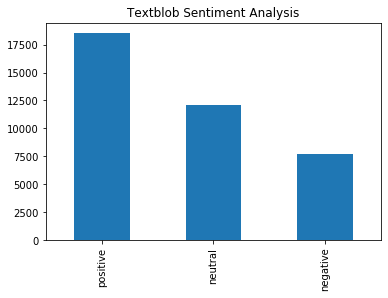

In [16]:
df.tb_sentiment.value_counts().plot(kind='bar',title="Textblob Sentiment Analysis")

Overall, sentiment is mostly positive! One caveat is that Textblob is not necessarily 100% accurate, and many times interpretation can be subjective, especially when the tweet itself is negative but the overall opinion toward vaccines is conveyed as positive. 

To look deeper into positive vs negative, I'm going to show the most frequent words and visualize with a word cloud.

In [17]:
negatives = df[df['tb_sentiment'] == 'negative']
positives = df[df['tb_sentiment'] == 'positive']

In [18]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

In [19]:
def tokenize(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [word.lower() for word in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

In [20]:
processed_data_positive = list(map(tokenize, positives['clean_text']))

processed_data_positive[0]

['definitely',
 'required',
 'every',
 'public',
 'location',
 'library',
 'dmv',
 'etc',
 'also',
 'private',
 'locations',
 'grocery',
 'stores',
 'etc',
 'countries',
 'suffering',
 'lol',
 'us',
 'japan',
 'still',
 'state',
 'emergency',
 'canada',
 'barely',
 'vaccines',
 'virus',
 'ca',
 "n't",
 'stopped']

In [21]:
processed_data_negative = list(map(tokenize, negatives['clean_text']))

processed_data_negative[0]

['hit',
 'today',
 'talmbout',
 'need',
 'sit',
 'talk',
 'heart',
 'dropped',
 "'m",
 'like',
 'granny',
 'say',
 'vaccine',
 'gon',
 'na',
 'get',
 'ðÿ˜',
 '’']

In [22]:
pos_tweet_concat = []
for tweet in processed_data_positive:
    pos_tweet_concat += tweet
    
pos_tweet_freqdist = FreqDist(pos_tweet_concat)
pos_tweet_freqdist.most_common(2000)

[('vaccine', 16249),
 ("'s", 4576),
 ('get', 4332),
 ('vaccines', 4042),
 ("n't", 3947),
 ('covid', 2955),
 ('people', 2605),
 ('first', 2399),
 ('got', 2231),
 ('amp', 2230),
 ("'m", 1898),
 ('getting', 1579),
 ('new', 1524),
 ('dose', 1503),
 ('like', 1409),
 ('one', 1335),
 ('today', 1267),
 ('vaccinated', 1240),
 ('’', 1192),
 ('covid-19', 1175),
 ('shot', 1156),
 ('ðÿ', 1090),
 ('good', 1084),
 ("'re", 994),
 ('covid19', 963),
 ('us', 953),
 ('know', 942),
 ('would', 930),
 ('need', 907),
 ('still', 892),
 ('many', 892),
 ('take', 844),
 ('right', 772),
 ('time', 771),
 ('pfizer', 770),
 ('day', 757),
 ('available', 743),
 ('second', 734),
 ('make', 724),
 ('also', 719),
 ('even', 717),
 ('really', 707),
 ("'ve", 705),
 ('moderna', 702),
 ('go', 699),
 ('appointment', 672),
 ('see', 663),
 ('going', 661),
 ('everyone', 658),
 ('”', 648),
 ('better', 645),
 ('much', 632),
 ('work', 628),
 ('ca', 625),
 ('great', 624),
 ('back', 622),
 ('think', 621),
 ('year', 616),
 ('want', 608),

In [23]:
neg_tweet_concat = []
for tweet in processed_data_negative:
    neg_tweet_concat += tweet
    
neg_tweet_freqdist = FreqDist(neg_tweet_concat)
neg_tweet_freqdist.most_common(2000)

[('vaccine', 6739),
 ("n't", 2285),
 ("'s", 2052),
 ('get', 1742),
 ('vaccines', 1637),
 ('people', 1303),
 ('covid', 1210),
 ("'m", 913),
 ('got', 855),
 ('like', 787),
 ('amp', 761),
 ('getting', 710),
 ('one', 551),
 ("'re", 464),
 ('take', 457),
 ('vaccinated', 434),
 ('would', 434),
 ('still', 428),
 ('us', 411),
 ('know', 368),
 ('go', 365),
 ('even', 351),
 ('going', 350),
 ('dose', 346),
 ('bad', 346),
 ('want', 338),
 ('shot', 335),
 ('ca', 334),
 ('need', 333),
 ('second', 331),
 ('shit', 326),
 ('covid-19', 318),
 ("'ve", 310),
 ('today', 303),
 ('think', 301),
 ('time', 300),
 ('also', 283),
 ('day', 278),
 ('sick', 275),
 ('trump', 273),
 ('’', 270),
 ('long', 260),
 ('ðÿ', 259),
 ('new', 257),
 ('work', 254),
 ('make', 250),
 ('really', 245),
 ('first', 245),
 ('covid19', 245),
 ('fucking', 242),
 ('virus', 237),
 ('could', 234),
 ('year', 232),
 ('least', 229),
 ('2', 229),
 ('pfizer', 222),
 ('appointment', 222),
 ('feel', 221),
 ('rollout', 220),
 ('black', 219),
 ('si

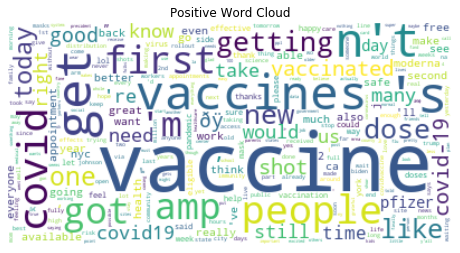

In [25]:
p_wc = WordCloud(background_color="white", max_words=2000)
p_wc.generate_from_frequencies(pos_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()


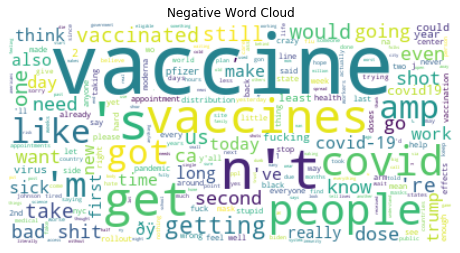

In [26]:
n_wc = WordCloud(background_color="white", max_words=2000)
n_wc.generate_from_frequencies(neg_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(n_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Negative Word Cloud')
plt.show()

WC Analysis


Next, I want to create a dataframe that shows how sentiment trends over time, which I'll use to correlate with the vaccination rate data.

In [27]:
sent_over_time = df[['date', 'tb_polarity']].sort_values(by ='date')
sent_over_time['date'] =pd.to_datetime(sent_over_time['date'])
sent_over_time = sent_over_time.groupby('date').mean()

Text(0.5, 1.0, 'Polarity Score Over Time')

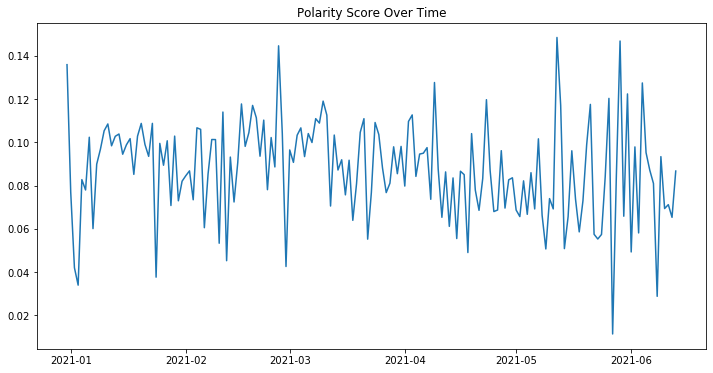

In [38]:
fig = plt.figure(figsize=(12, 6))
plt.plot(sent_over_time)
plt.title("Polarity Score Over Time")

Overall, the trend looks pretty random. Let's take a closer look at different locations. 

In [41]:
def sent_by_location(df, location):
    location_df = df[df['geo'] == location]
    return location_df[['date', 'tb_polarity']].sort_values(by ='date').groupby('date').mean()

In [42]:
hou_df = sent_by_location(df, 'houston')
chi_df = sent_by_location(df, 'chicago')
nyc_df = sent_by_location(df, 'nyc')
la_df = sent_by_location(df, 'la')

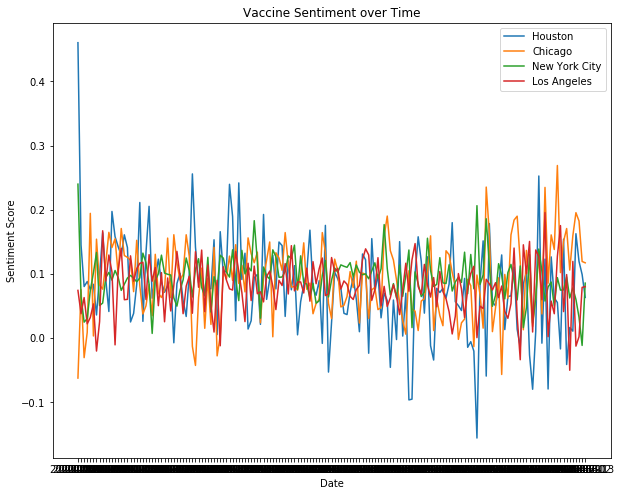

In [45]:
fig = plt.figure(figsize=(10, 8))
plt.plot(hou_df, label='Houston')  # Plot some data on the axes.
plt.plot(chi_df, label='Chicago')  # Plot more data on the axes...
plt.plot(nyc_df, label='New York City')
plt.plot(la_df, label='Los Angeles')
plt.xlabel('Date')  # Add an x-label to the axes.
plt.ylabel('Sentiment Score')  # Add a y-label to the axes.
plt.title("Vaccine Sentiment over Time")  # Add a title to the axes.
plt.legend()  # Add a legend.

In [91]:
chi_df

,tb_polarity
date,
2020-12-31,-0.062332
2021-01-01,0.075789
2021-01-02,-0.030495
2021-01-03,0.008889
2021-01-04,0.194413
...,...
2021-06-09,0.159430
2021-06-10,0.195480
2021-06-11,0.182482


## Cluster Analysis

https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [55]:
df[['clean_text']]

,clean_text
0,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped."
1,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,Sogard avoided that tag at second like it was the COVID vaccine
4,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist."
...,...
38338,is a total failure. Trump &amp; his administration couldn't even successfully roll out the covid19 vaccine. Millions of doses are just sitting around. The Trump administration is the worst in US history. LoserTrump LockUpTheTrumpCrimeFamily
38339,"According to President Trump's own former head of the FDA, Trump missed the window to effectively roll out the vaccine. President-Elect Biden will get his chance to take over the effort in 20 days."
38340,Literally someone tell me where in LA I can be hired to give out vaccines. I am available and this is ridiculous to me.
38341,And this is why I never put much hope in a vaccine. No fucking way this country figures out how to distribute it properly.


In [ ]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train))
X_train_tokenized = tokenizer.texts_to_sequences(X_train)

X_train_token = sequence.pad_sequences(X_train_tokenized, maxlen=100)


In [65]:
# applying my tokenizing function to all data now
processed_data = list(map(tokenize, df['clean_text']))

In [67]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .90, 
                        use_idf=True)

tfidf_text= tfidf.fit_transform(df['clean_text'])

In [88]:
tfidf_text

<38343x31765 sparse matrix of type '<class 'numpy.float64'>'
	with 512517 stored elements in Compressed Sparse Row format>

In [70]:
#creating a dataframe so I can preview the results of TF-IDF
tfidf_test_df = pd.DataFrame(tfidf_text.toarray(), columns=tfidf.get_feature_names())

# Grabbing a vectorized row
test_doc = tfidf_test_df.iloc[8]
print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

tinnitus      0.405978
downplay      0.397069
bizarre       0.353205
suspicious    0.350628
legitimate    0.325529
effect        0.251413
doctor        0.242504
told          0.225655
things        0.223531
get           0.212561
side          0.191639
people        0.129481
vaccine       0.047746
Name: 8, dtype: float64


In [78]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(tfidf_text)
cluster_assignments = kmeans.predict(tfidf_text) 

In [75]:
cluster_assignments = kmeans.predict(tfidf_text) 

In [79]:
# from sklearn.metrics import calinski_harabasz_score

# print(calinski_harabasz_score(tfidf_text, cluster_assignments))

ValueError: 'c' argument has 38343 elements, which is not acceptable for use with 'x' with size 38343, 'y' with size 38343.

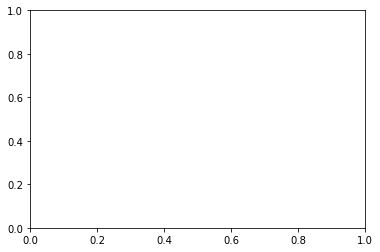

In [83]:
plt.scatter(tfidf_text[:, 0], tfidf_text[:, 1], c=cluster_assignments, s=10);

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=70);

In [84]:
k_means_3 = KMeans(n_clusters=3).fit(tfidf_text)
k_means_4 = KMeans(n_clusters=4).fit(tfidf_text)
k_means_5 = KMeans(n_clusters=5).fit(tfidf_text)
k_means_6 = KMeans(n_clusters=6).fit(tfidf_text)
k_means_7 = KMeans(n_clusters=7).fit(tfidf_text)

k_list = [k_means_3, k_means_4, k_means_5, k_means_6, k_means_7]

In [87]:
CH_score = []

for i in k_list:
    labels = i.labels_
    score = calinski_harabasz_score(tfidf_text.toarray(), labels)
    CH_score.append(score)

MemoryError: Unable to allocate 821. MiB for an array with shape (3386, 31765) and data type float64

In [ ]:
plt.plot([3, 4, 5, 6, 7], CH_score)
plt.xticks([3,4,5,6,7])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()